In [1]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
import pyodbc

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [39]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGDATIX;'
                            'DATABASE=DatixCRM;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_notes from DatixCRM.dbo.incidents_main where inc_type='PAT' and inc_category='MEDIC'"
df = pd.read_sql(query, sql_conn)
df.head()

,inc_organisation,inc_locactual,inc_unit,inc_specialty,inc_loctype,inc_result,inc_severity,show_other_contacts,show_employee,show_witness,show_document,inc_reportedby,inc_notes
0,QA,E6/7,MEDMED,RESP,WARD,NOHARM,NONE,None,N,N,N,None,on drug rounds found Amlodipine not given for ...
1,QA,C5,MEDMED,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...
2,QA,EMERG,MEDUR,ED,AE,NOHARM,NONE,None,N,N,N,Other,"Resus controlled order booked went missing, ha..."
3,QA,C7,MEDMED,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...
4,QA,D5,SURMHN,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,I was giving the oral medication(CD-oxycodone)...


In [40]:
df['division'] = df['inc_unit'].str[:3]
df['care group'] = df['inc_unit'].str[3:6]
df = df.drop('inc_unit',axis=1)

In [41]:
df.columns = [column.replace('inc_organisation','site') for column in df.columns]
df.columns = [column.replace('inc_locactual','ward/dept/unit') for column in df.columns]
df.columns = [column.replace('inc_unit','division & care group') for column in df.columns]
df.columns = [column.replace('inc_specialty','specialty') for column in df.columns]
df.columns = [column.replace('inc_loctype','location type') for column in df.columns]
df.columns = [column.replace('inc_result','result') for column in df.columns]
df.columns = [column.replace('inc_severity','severity') for column in df.columns]
df.columns = [column.replace('inc_reportedby','reported by') for column in df.columns]
df.columns = [column.replace('show_other_contacts','other patients involved?') for column in df.columns]
df.columns = [column.replace('show_employee','other employees involved?') for column in df.columns]
df.columns = [column.replace('show_witness','any witnesses?') for column in df.columns]
df.columns = [column.replace('show_document','any documents attached?') for column in df.columns]
df.head()

,site,ward/dept/unit,specialty,location type,result,severity,other patients involved?,other employees involved?,any witnesses?,any documents attached?,reported by,inc_notes,division,care group
0,QA,E6/7,RESP,WARD,NOHARM,NONE,None,N,N,N,None,on drug rounds found Amlodipine not given for ...,MED,MED
1,QA,C5,GENMED,WARD,HARM,LOW,None,Y,Y,Y,None,HAEMOPHILIA PATIENT\r\n\r\nPATIENT NOT ADMINIS...,MED,MED
2,QA,EMERG,ED,AE,NOHARM,NONE,None,N,N,N,Other,"Resus controlled order booked went missing, ha...",MED,UR
3,QA,C7,CARDIO,WARD,NOHARM,NONE,None,Y,N,N,Other (Nurse / Midwife ),MIDAZOLAM SIGNED OUT OF CD BOOK FOR PATIENT . ...,MED,MED
4,QA,D5,ORTHO,WARD,NOHARM,NONE,None,N,N,N,Nurse,I was giving the oral medication(CD-oxycodone)...,SUR,MHN


In [42]:
df = df
category_columns = list(df.columns.values)
category_columns.remove('inc_notes')
count_accuracies = []
tfidf_accuracies = []
for column in category_columns:
    df_dropped = df.dropna(subset=[column])
    y = df_dropped[column]
    X_train, X_test, y_train, y_test = train_test_split(
                                    df_dropped['inc_notes'], y,
                                    test_size=0.33,
                                    random_state=53)
    count_vectorizer = CountVectorizer(stop_words='english')
    count_train = count_vectorizer.fit_transform(X_train.values)
    count_test = count_vectorizer.transform(X_test.values)
    # Print the first 10 features of the count_vectorizer
    #print(count_vectorizer.get_feature_names()[:10])


    # Initialize a TfidfVectorizer object: tfidf_vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df=0.7)

    # Transform the training data: tfidf_train 
    tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

    # Transform the test data: tfidf_test 
    tfidf_test = tfidf_vectorizer.transform(X_test.values)

    # Print the first 10 features
    #print(tfidf_vectorizer.get_feature_names()[:10])

    # Print the first 5 vectors of the tfidf training data
    #print(tfidf_train.A[:5])


    # Create the CountVectorizer DataFrame: count_df
    #count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())

    # Create the TfidfVectorizer DataFrame: tfidf_df
    #tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())

    # Print the head of count_df
    #print(count_df.head())

    # Print the head of tfidf_df
    #print(tfidf_df.head())

    # Calculate the difference in columns: difference
    #difference = set(count_df.columns) - set(tfidf_df.columns)
    #print(difference)

    # Check whether the DataFrames are equal
    #print(count_df.equals(tfidf_df))


    count_nb_classifier = MultinomialNB()
    count_nb_classifier.fit(count_train, y_train)
    count_pred = count_nb_classifier.predict(count_test)
    count_accuracies.append(100*metrics.accuracy_score(y_test,count_pred))
    
    tfidf_nb_classifier = MultinomialNB()
    tfidf_nb_classifier.fit(tfidf_train, y_train)
    tfidf_pred = tfidf_nb_classifier.predict(tfidf_test)
    tfidf_accuracies.append(100*metrics.accuracy_score(y_test,tfidf_pred))    

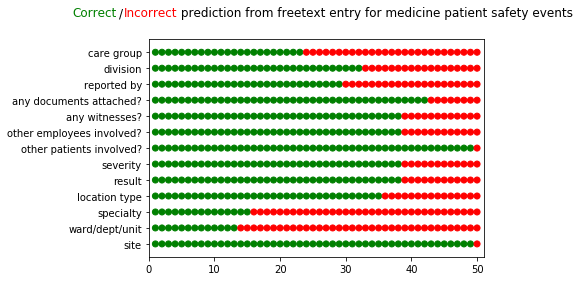

In [43]:
count_from50 = [int(round(accuracy/2)) for accuracy in count_accuracies]
n_category_columns = len(category_columns)
colors = [['green' if count_from50[j]>i else 'red' for j in range(n_category_columns)] for i in range(50)]
#category_columns = [column.replace('inc_organisation','site') for column in category_columns]
#category_columns = [column.replace('inc_locactual','ward/dept/unit') for column in category_columns]
#category_columns = [column.replace('inc_unit','division & care group') for column in category_columns]
#category_columns = [column.replace('inc_specialty','specialty') for column in category_columns]
#category_columns = [column.replace('inc_loctype','location type') for column in category_columns]
#category_columns = [column.replace('inc_result','result') for column in category_columns]
#category_columns = [column.replace('inc_severity','severity') for column in category_columns]
#category_columns = [column.replace('inc_reportedby','reported by') for column in category_columns]
#category_columns = [column.replace('show_other_contacts','other patients involved?') for column in category_columns]
#category_columns = [column.replace('show_employee','other employees involved?') for column in category_columns]
#category_columns = [column.replace('show_witness','any witnesses?') for column in category_columns]
#category_columns = [column.replace('show_document','any documents attached?') for column in category_columns]
for i in range(50):
    plt.scatter(x=np.ones(len(category_columns))*(i+1),y=category_columns,color=colors[i])
plt.xlim((0,51));
fig1 = plt.figure(1)
fig1.text(0, 0.95, "Correct", ha="center", va="bottom", size="large", color="green");
fig1.text(0.06, 0.95, "/", ha="center", va="bottom", size="large");
fig1.text(0.13,0.95,"Incorrect", ha="center", va="bottom", size="large", color="red");
fig1.text(0.19, 0.95, " prediction from freetext entry for medicine patient safety events", va="bottom", size="large");

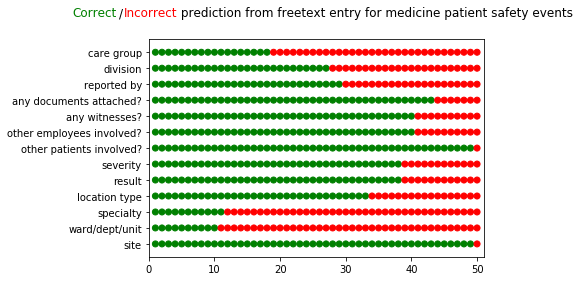

In [44]:
tfidf_from50 = [int(round(accuracy/2)) for accuracy in tfidf_accuracies]
colors = [['green' if tfidf_from50[j]>i else 'red' for j in range(n_category_columns)] for i in range(50)]
for i in range(50):
    plt.scatter(x=np.ones(len(category_columns))*(i+1),y=category_columns,color=colors[i])
plt.xlim((0,51));
fig1 = plt.figure(1)
fig1.text(0, 0.95, "Correct", ha="center", va="bottom", size="large", color="green");
fig1.text(0.06, 0.95, "/", ha="center", va="bottom", size="large");
fig1.text(0.13,0.95,"Incorrect", ha="center", va="bottom", size="large", color="red");
fig1.text(0.19, 0.95, " prediction from freetext entry for medicine patient safety events", va="bottom", size="large");

In [65]:
non_crammed_columns = [column for column in category_columns]
non_crammed_columns.remove('ward/dept/unit')
non_crammed_columns.remove('specialty')
non_crammed_columns.remove('reported by')

In [72]:
def plot_count_confusion_matrix():
    count_accuracies = []
    for column in non_crammed_columns:
        df_dropped = df.dropna(subset=[column])
        df_dropped = df_dropped[df_dropped[column]!='']
        classes = [str(i) for i in df_dropped[column].value_counts().index]
        mapping = dict((el,i) for i,el in enumerate(classes)) 
        df_replaced = df_dropped.replace({column: mapping})
        y = df_replaced[column]
        X_train, X_test, y_train, y_test = train_test_split(
                                        df_dropped['inc_notes'], y,
                                        test_size=0.33,
                                        random_state=53)
        count_vectorizer = CountVectorizer(stop_words='english')
        count_train = count_vectorizer.fit_transform(X_train.values)
        count_test = count_vectorizer.transform(X_test.values)

        count_nb_classifier = MultinomialNB()
        count_nb_classifier.fit(count_train, y_train)
        count_pred = count_nb_classifier.predict(count_test)
        count_accuracies.append(100*metrics.accuracy_score(y_test,count_pred))

        cm = metrics.confusion_matrix(y_test, count_pred, labels=list(mapping.values()))
    
        plt.figure();
        # https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        fig, ax = plt.subplots(figsize=(11,11));
        im = ax.imshow(cm, cmap=plt.cm.Blues);
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ax.figure.colorbar(im, cax=cax)
        #plt.title('True vs Predicted "'+str(column)+'" from freetext of medicine patient safety events',x=1.2)        
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title='True vs Predicted "'+str(column)+'" from freetext of medicine patient safety events',
               ylabel='True label',
               xlabel='Predicted label');
        ax.xaxis.set_label_coords(1.06, -0.01);

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor");

        # Loop over data dimensions and create text annotations.
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black");
        fig.tight_layout();
        plt.show();

<Figure size 432x288 with 0 Axes>

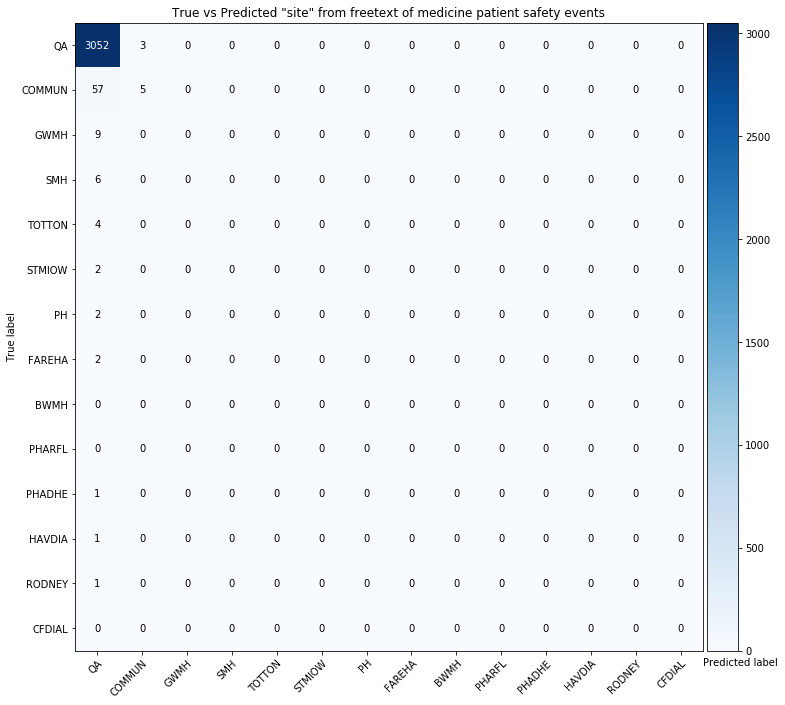

<Figure size 432x288 with 0 Axes>

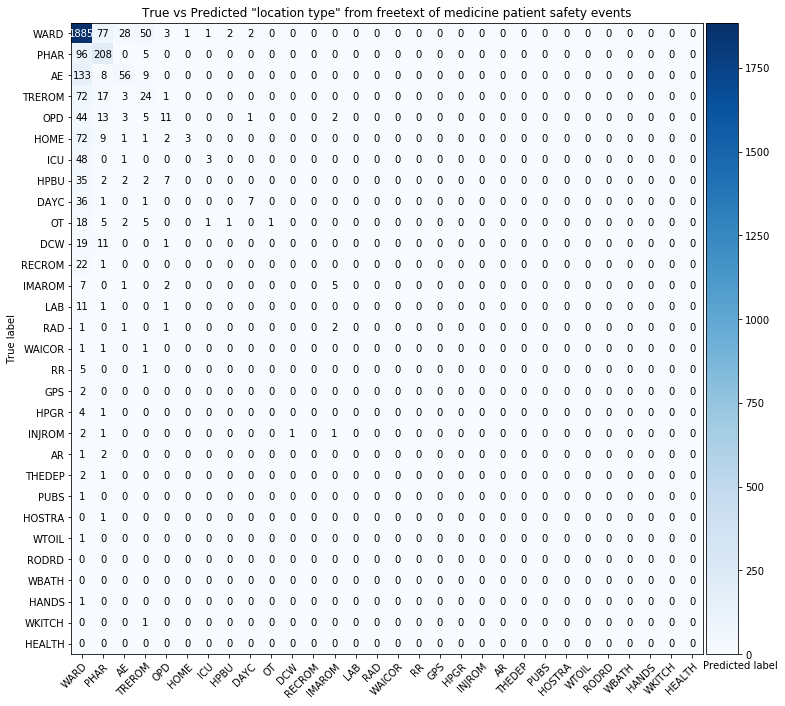

<Figure size 432x288 with 0 Axes>

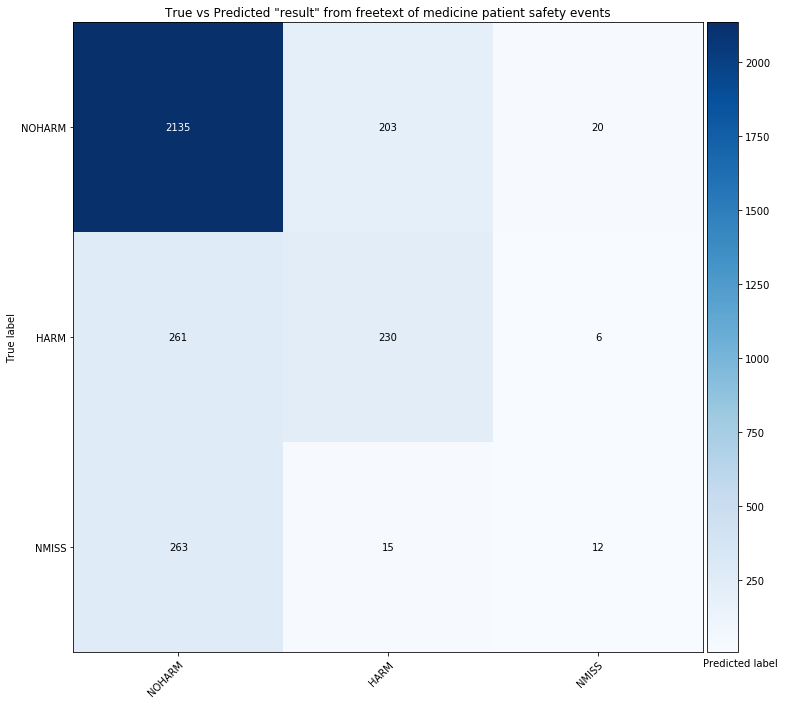

<Figure size 432x288 with 0 Axes>

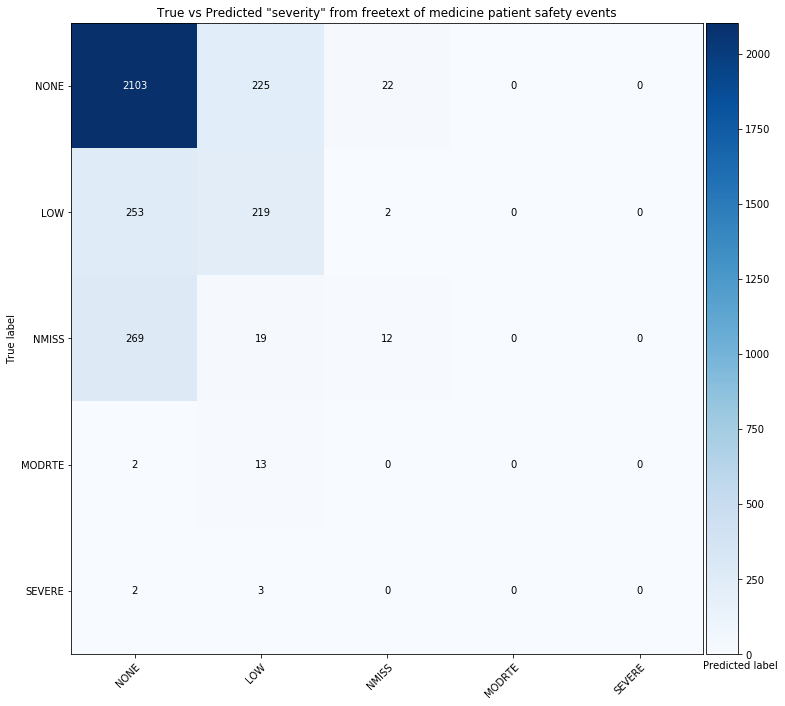

<Figure size 432x288 with 0 Axes>

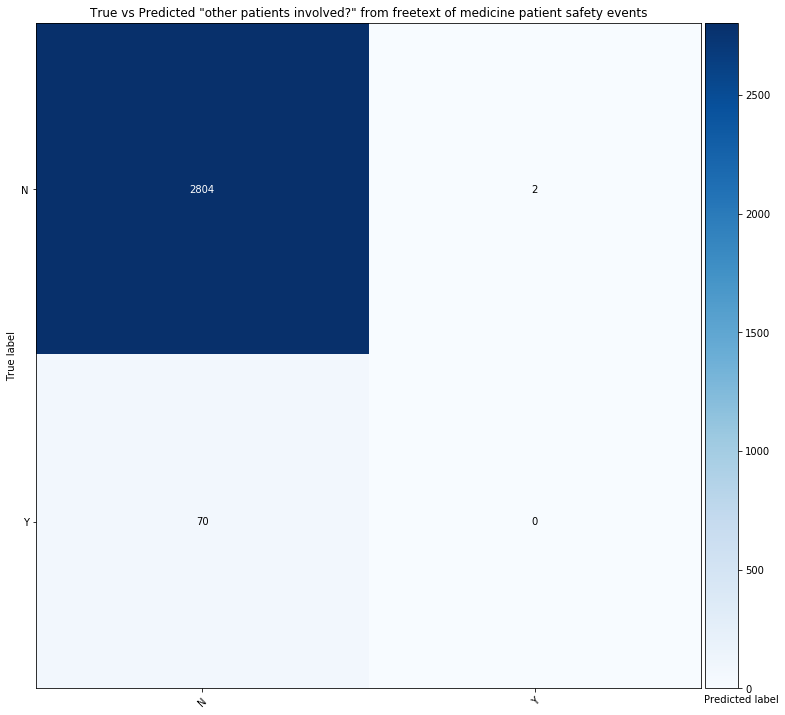

<Figure size 432x288 with 0 Axes>

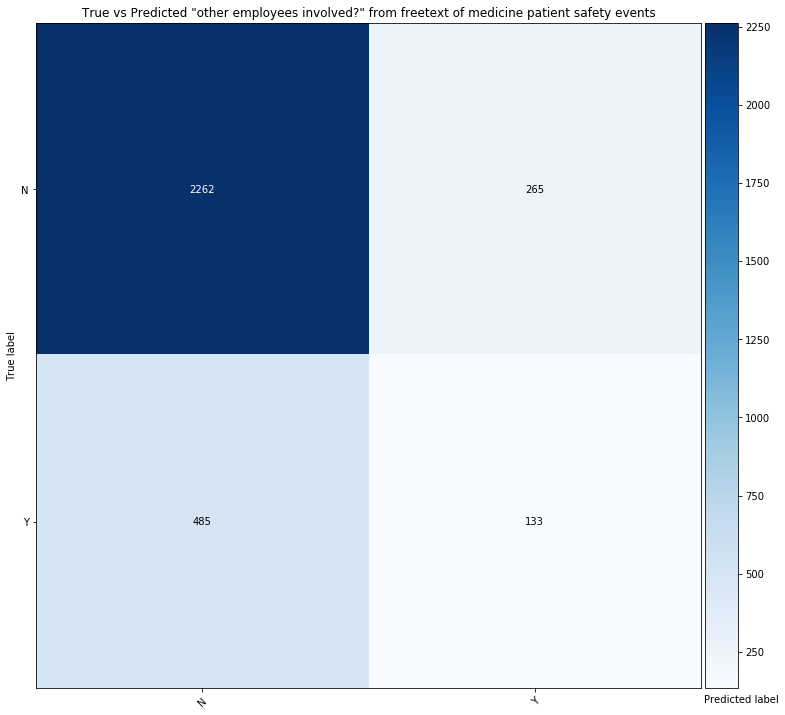

<Figure size 432x288 with 0 Axes>

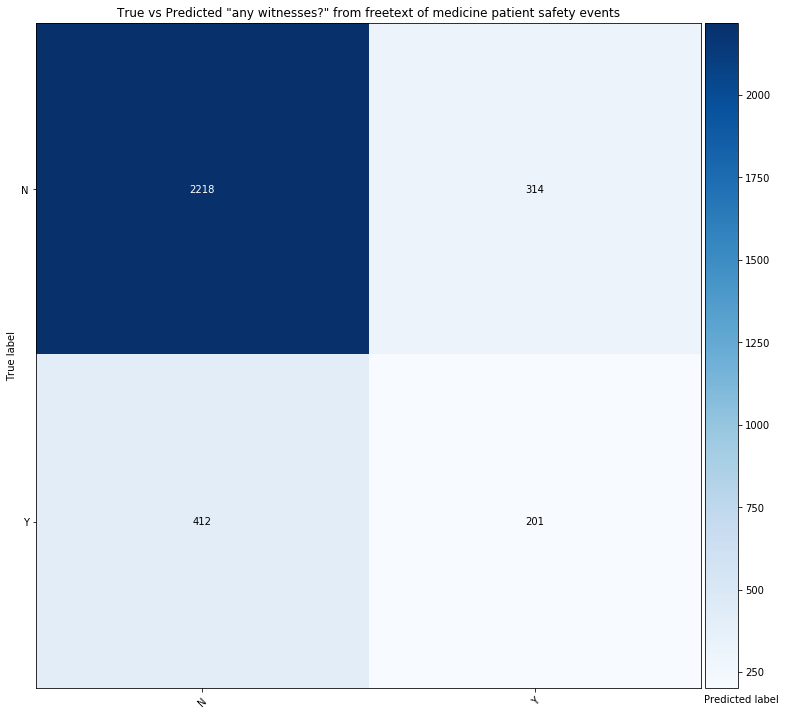

<Figure size 432x288 with 0 Axes>

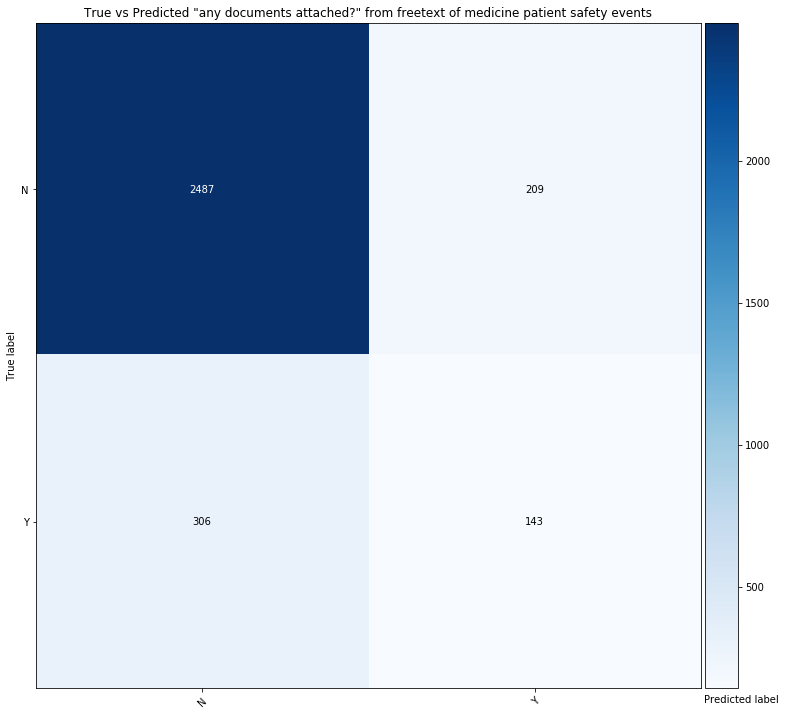

<Figure size 432x288 with 0 Axes>

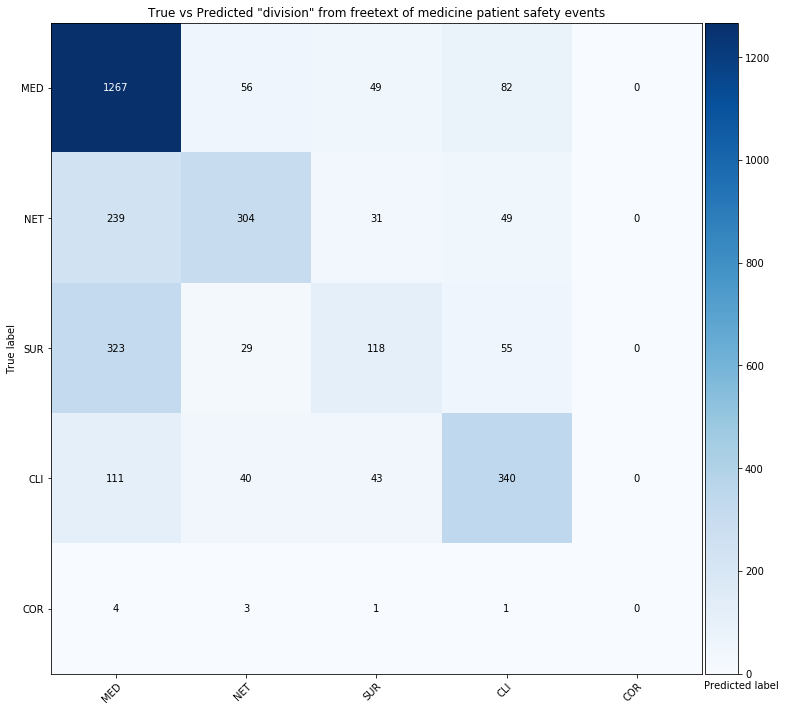

<Figure size 432x288 with 0 Axes>

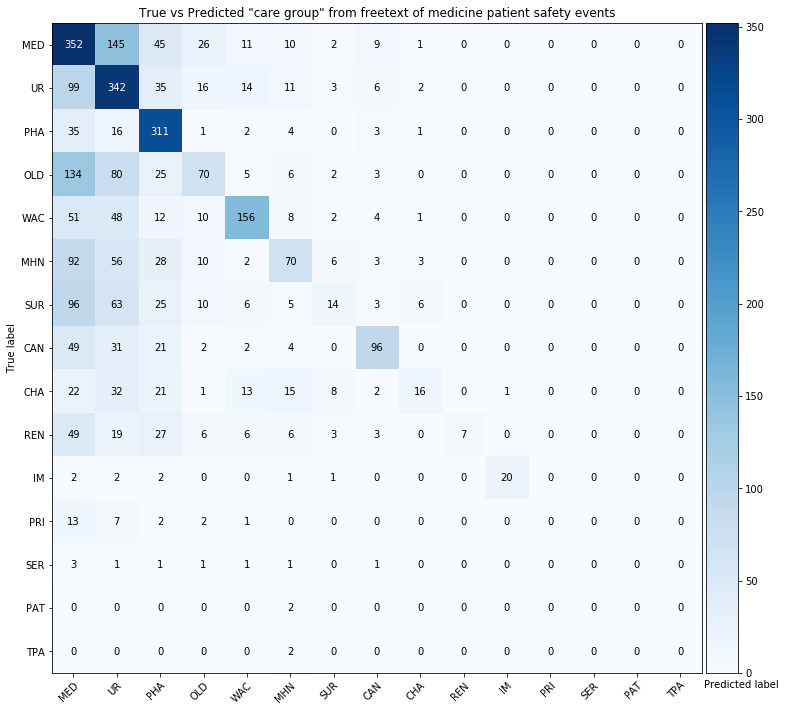

In [73]:
plot_count_confusion_matrix()

In [66]:
def plot_tfidf_confusion_matrix():
    tfidf_accuracies = []
    for column in non_crammed_columns:
        df_dropped = df.dropna(subset=[column])
        df_dropped = df_dropped[df_dropped[column]!='']
        classes = [str(i) for i in df_dropped[column].value_counts().index]
        mapping = dict((el,i) for i,el in enumerate(classes)) 
        df_replaced = df_dropped.replace({column: mapping})
        y = df_replaced[column]
        X_train, X_test, y_train, y_test = train_test_split(
                                        df_dropped['inc_notes'], y,
                                        test_size=0.33,
                                        random_state=53)
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)
        tfidf_test = tfidf_vectorizer.transform(X_test.values)

        tfidf_nb_classifier = MultinomialNB()
        tfidf_nb_classifier.fit(tfidf_train, y_train)
        tfidf_pred = tfidf_nb_classifier.predict(tfidf_test)
        tfidf_accuracies.append(100*metrics.accuracy_score(y_test,tfidf_pred))

        cm = metrics.confusion_matrix(y_test, tfidf_pred, labels=list(mapping.values()))
    
        plt.figure();
        # https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
        fig, ax = plt.subplots(figsize=(11,11));
        im = ax.imshow(cm, cmap=plt.cm.Blues);
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ax.figure.colorbar(im, cax=cax)
        #plt.title('True vs Predicted "'+str(column)+'" from freetext of medicine patient safety events',x=1.2)        
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title='True vs Predicted "'+str(column)+'" from freetext of medicine patient safety events',
               ylabel='True label',
               xlabel='Predicted label');
        ax.xaxis.set_label_coords(1.06, -0.01);

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor");

        # Loop over data dimensions and create text annotations.
        fmt = 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black");
        fig.tight_layout();
        plt.show();

<Figure size 432x288 with 0 Axes>

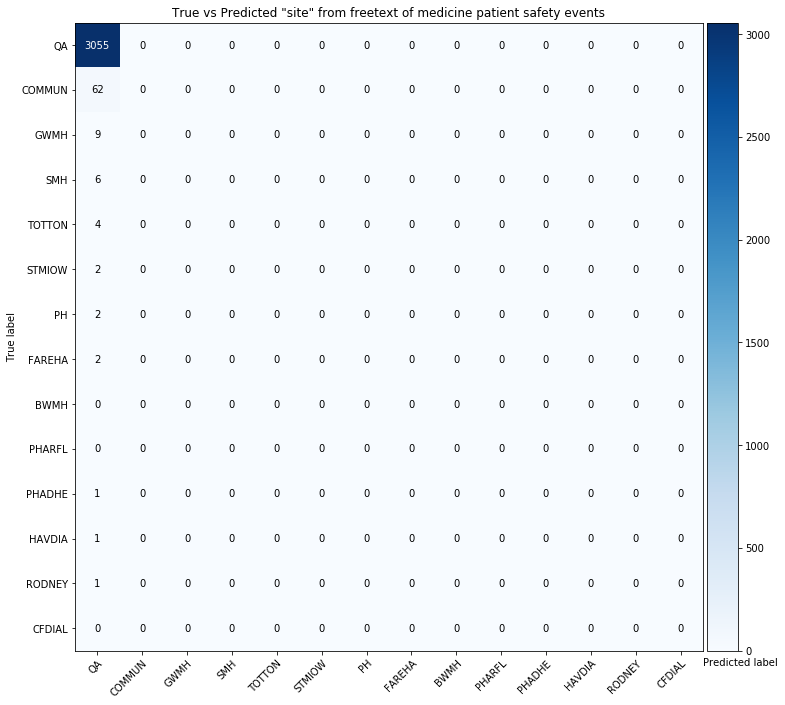

<Figure size 432x288 with 0 Axes>

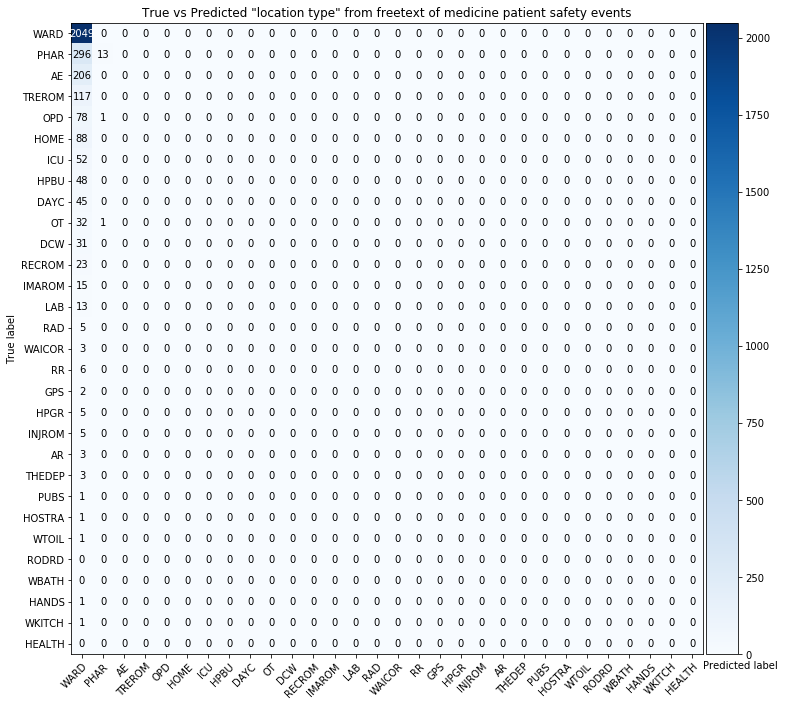

<Figure size 432x288 with 0 Axes>

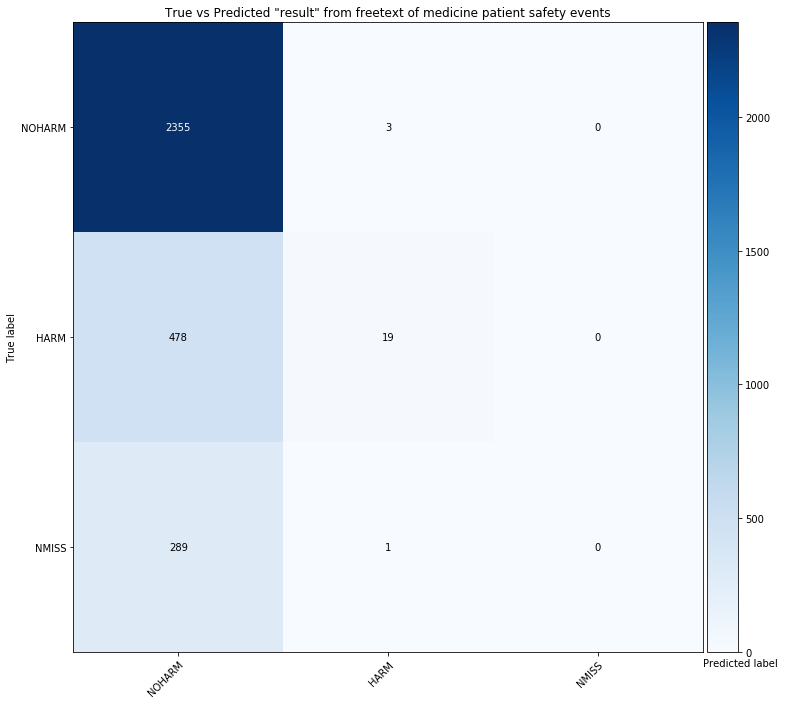

<Figure size 432x288 with 0 Axes>

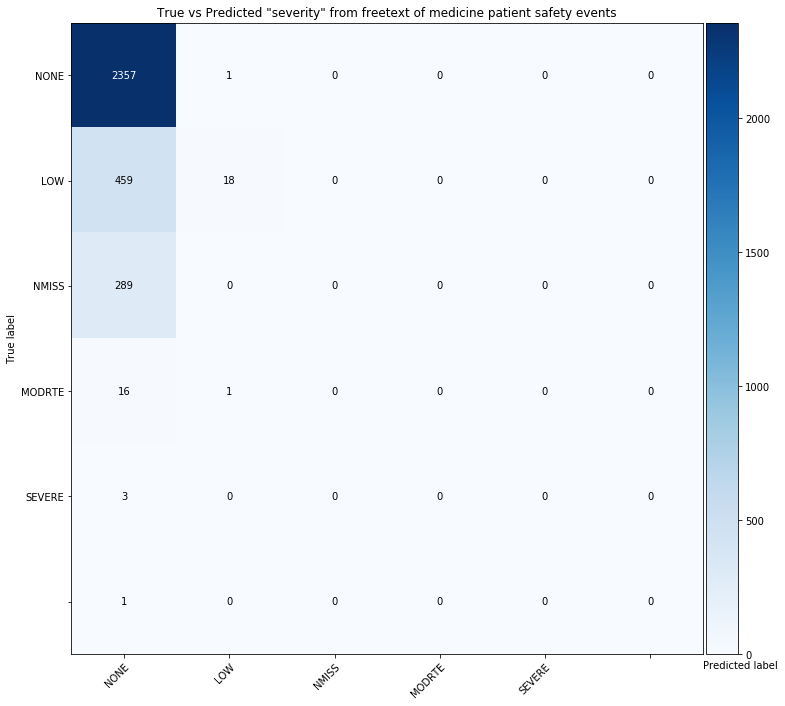

<Figure size 432x288 with 0 Axes>

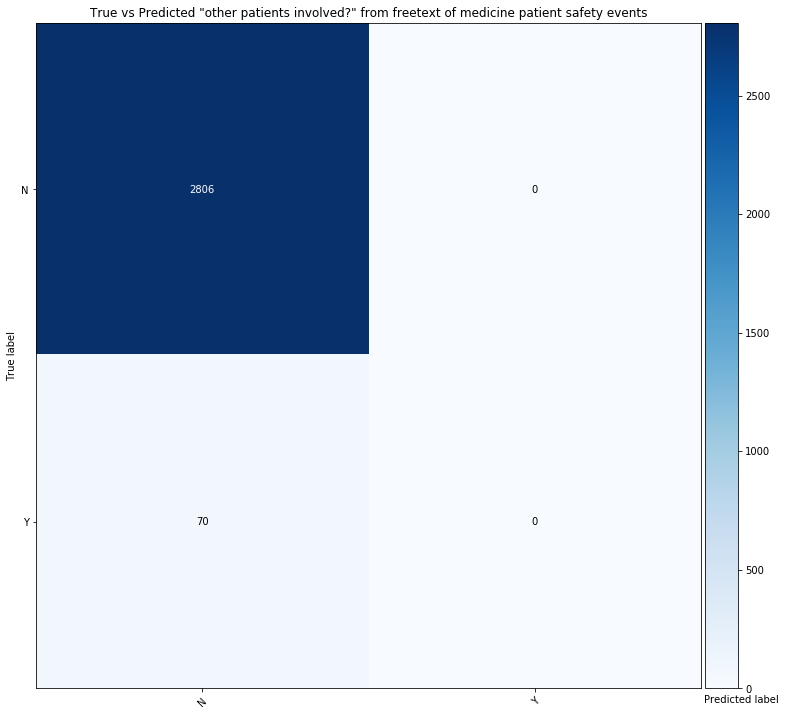

<Figure size 432x288 with 0 Axes>

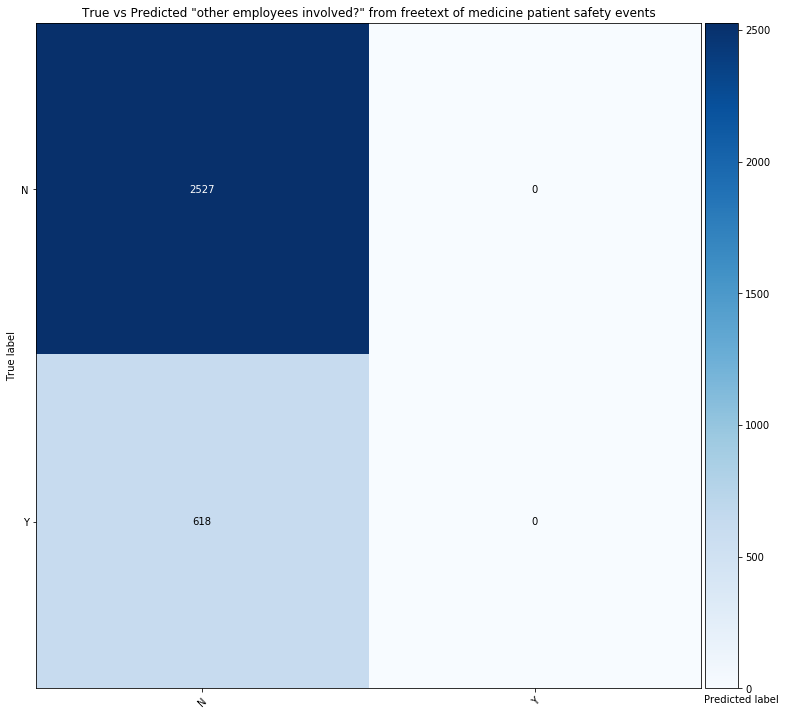

<Figure size 432x288 with 0 Axes>

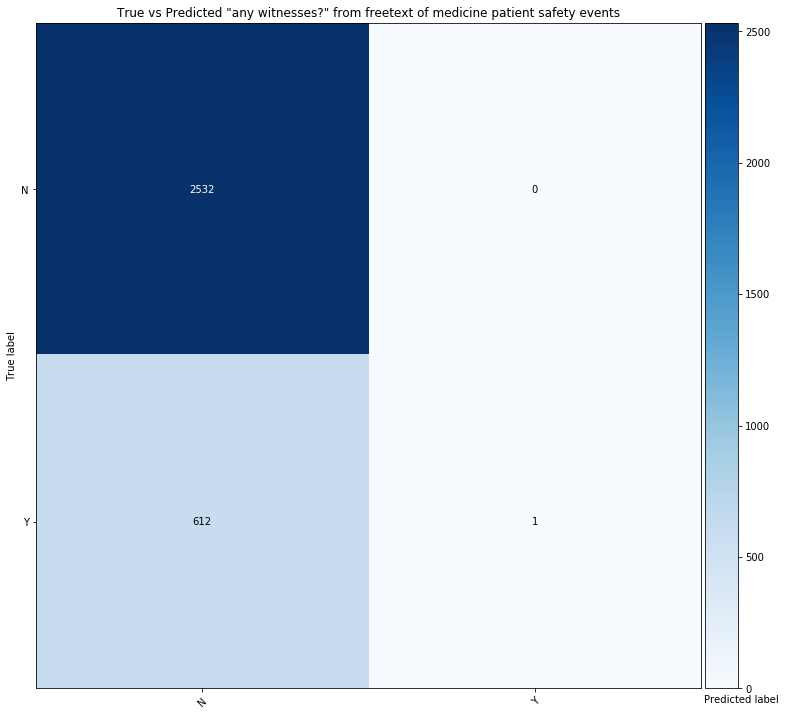

<Figure size 432x288 with 0 Axes>

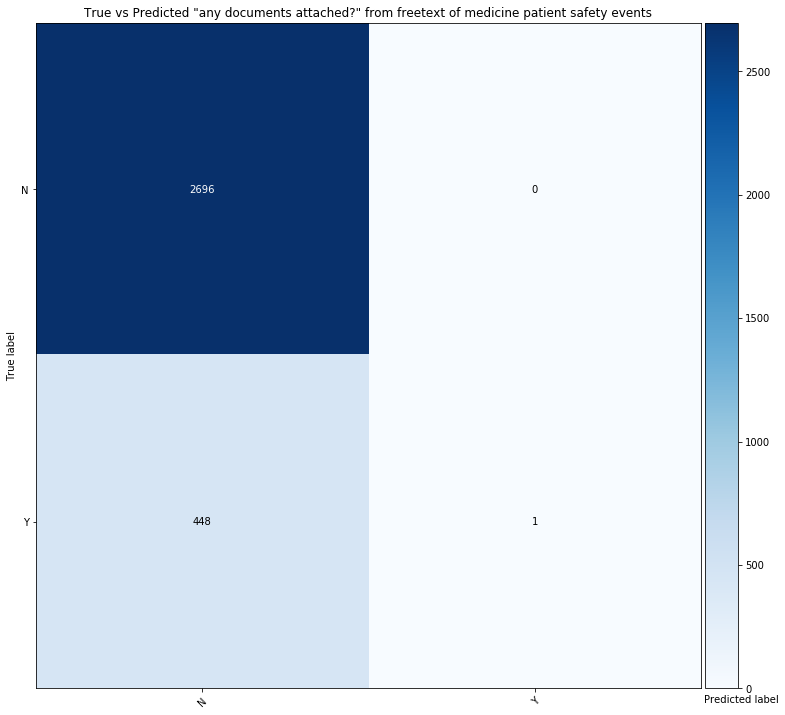

<Figure size 432x288 with 0 Axes>

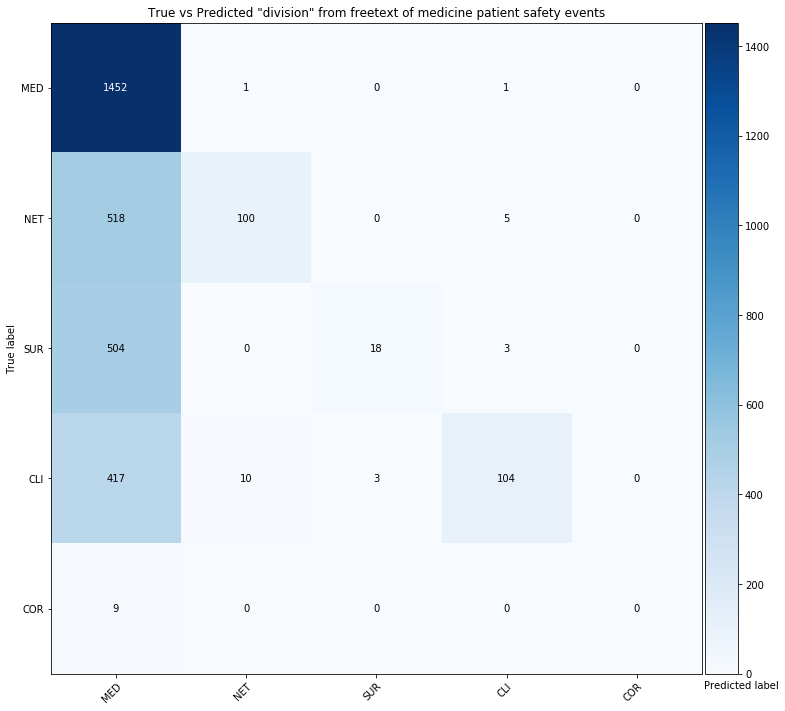

<Figure size 432x288 with 0 Axes>

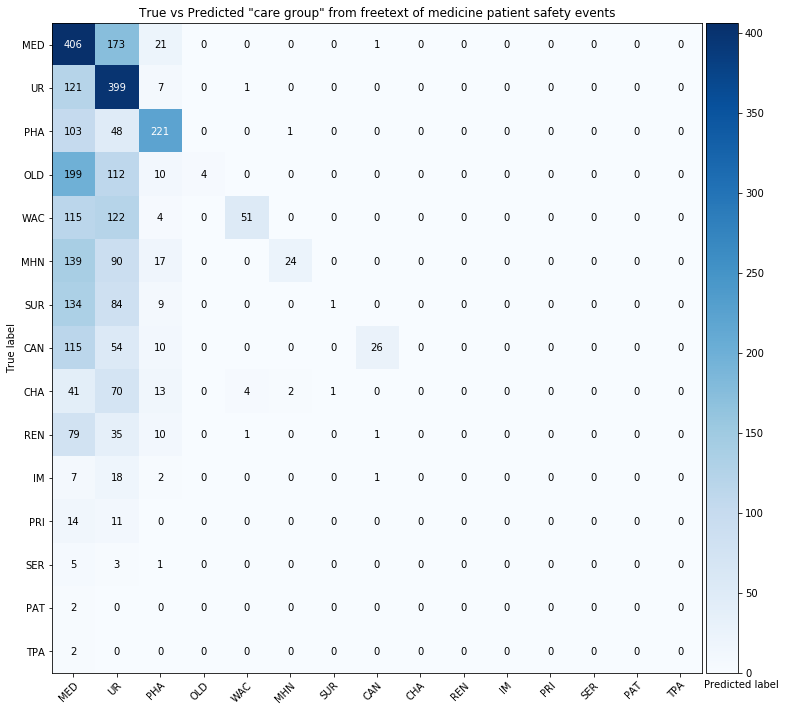

In [67]:
plot_tfidf_confusion_matrix()

In [68]:
# Create the list of alphas: alphas
alphas = np.arange(0.1,1,0.1)

# Define train_and_predict()
def count_train_and_predict(column,alpha):
    df_dropped = df.dropna(subset=[column])
    y = df_dropped[column]
    X_train, X_test, y_train, y_test = train_test_split(
                                    df_dropped['inc_notes'], y,
                                    test_size=0.33,
                                    random_state=53)

    # Initialize a CountVectorizer object: count_vectorizer
    count_vectorizer = CountVectorizer(stop_words="english")

    # Transform the training data: count_train 
    count_train = count_vectorizer.fit_transform(X_train.values)

    # Transform the test data: count_test 
    count_test = count_vectorizer.transform(X_test.values)
    
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(count_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(count_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test,pred)
    
    return score

In [69]:
# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    for column in category_columns:
        print('Column: ', column, ' Score: ', count_train_and_predict(column,alpha))
        print()

Alpha:  0.1
Column:  site  Score:  0.9710651828298887

Column:  ward/dept/unit  Score:  0.3106518282988871

Column:  specialty  Score:  0.34912559618441974

Column:  location type  Score:  0.6823529411764706

Column:  result  Score:  0.7186009538950715

Column:  severity  Score:  0.7116057233704293

Column:  other patients involved?  Score:  0.9700973574408901

Column:  other employees involved?  Score:  0.7208267090620032

Column:  any witnesses?  Score:  0.7367249602543721

Column:  any documents attached?  Score:  0.7958664546899841

Column:  reported by  Score:  0.5435750636132316

Column:  division  Score:  0.6384737678855326

Column:  care group  Score:  0.4559618441971383

Alpha:  0.2
Column:  site  Score:  0.9713831478537361

Column:  ward/dept/unit  Score:  0.30492845786963435

Column:  specialty  Score:  0.35262321144674086

Column:  location type  Score:  0.6890302066772656

Column:  result  Score:  0.7268680445151033

Column:  severity  Score:  0.7208267090620032

Column:  

In [70]:
# Create the list of alphas: alphas
alphas = np.arange(0.1,1,0.1)

# Define train_and_predict()
def tfidf_train_and_predict(column,alpha):
    df_dropped = df.dropna(subset=[column])
    y = df_dropped[column]
    X_train, X_test, y_train, y_test = train_test_split(
                                    df_dropped['inc_notes'], y,
                                    test_size=0.33,
                                    random_state=53)

    # Initialize a TfidfVectorizer object: tfidf_vectorizer
    tfidf_vectorizer = TfidfVectorizer(stop_words="english",max_df=0.7)

    # Transform the training data: tfidf_train 
    tfidf_train = tfidf_vectorizer.fit_transform(X_train.values)

    # Transform the test data: tfidf_test 
    tfidf_test = tfidf_vectorizer.transform(X_test.values)
    
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(tfidf_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(tfidf_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test,pred)
    
    # Get the class labels: class_labels
    class_labels = nb_classifier.classes_

    # Extract the features: feature_names
    feature_names = tfidf_vectorizer.get_feature_names()

    # Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
    feat_with_weights = sorted(zip(nb_classifier.coef_[0], feature_names))

    # Print the first class label and the bottom 20  feat_with_weights entries
    #for i in range(len(class_labels)):
    #    print(class_labels[i], feat_with_weights[-20:])
    
    return score

In [71]:
# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    for column in category_columns:
        print('Column: ', column, ' Score: ', tfidf_train_and_predict(column,alpha))
        print()

Alpha:  0.1
Column:  site  Score:  0.9717011128775834

Column:  ward/dept/unit  Score:  0.2597774244833068

Column:  specialty  Score:  0.32368839427662954

Column:  location type  Score:  0.7014308426073131

Column:  result  Score:  0.7732909379968204

Column:  severity  Score:  0.7697933227344992

Column:  other patients involved?  Score:  0.9756606397774688

Column:  other employees involved?  Score:  0.7984101748807632

Column:  any witnesses?  Score:  0.8019077901430842

Column:  any documents attached?  Score:  0.8600953895071543

Column:  reported by  Score:  0.5966921119592875

Column:  division  Score:  0.6470588235294118

Column:  care group  Score:  0.45691573926868045

Alpha:  0.2
Column:  site  Score:  0.9713831478537361

Column:  ward/dept/unit  Score:  0.2397456279809221

Column:  specialty  Score:  0.29634340222575517

Column:  location type  Score:  0.6880763116057234

Column:  result  Score:  0.772972972972973

Column:  severity  Score:  0.7691573926868045

Column:  o